In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import pathlib
import time as tt
import pickle

import matplotlib.pyplot as plt 
import seaborn as sns
from numpy.linalg import norm
from tqdm import tqdm
windows = [1, 10, 50]
print(os.getcwd())

/media/thomas/LaCie/Documents/financial_big_data/financial_big_data


In [2]:
"_"*100

'____________________________________________________________________________________________________'

In [3]:
fold = pathlib.Path(os.getcwd()+'/data/raw/dukascopy')
files_pq = [file for file in list(fold.rglob("*")) if file.name[-8:] == '.parquet']

In [4]:
fold

PosixPath('/media/thomas/LaCie/Documents/financial_big_data/financial_big_data/data/raw/dukascopy')

In [5]:
names = [i.name.split('-')[0] for i in files_pq[:50]]

In [6]:
#from lecture's notebook
def covariance_Hayashi_Yoshida(asset1, asset2):
    asset1 = asset1.rename({'logret': '1'}, axis=1)
    asset2 = asset2.rename({'logret': '2'}, axis=1)
    
    # Join the two DataFrames on their index and fill any missing values forward
    logret12 = pd.DataFrame(asset1).join(pd.DataFrame(asset2), how="outer")
    logret12.ffill(inplace=True)
    # Calculate the covariance of the two assets
    cov = (logret12["1"] * logret12["2"]).sum()
    return cov

In [7]:
#our own naive implementation
def covariance_Hayashi_Yoshida_slow(asset1, asset2):
    overlap = 0
    cov = 0
    prev_date1 = asset1.index[0]
    for date1, return1 in zip(asset1.index[1:], asset1['price'][1:]):
        prev_date2 = asset2.index[0]        
        for date2, return2 in zip(asset2.index[1:], asset2['price'][1:]):
            if max(prev_date1, prev_date2) < min(date1, date2):
                cov += return1*return2
                overlap += 1
                
            prev_date2 = date2
        prev_date1 = date1
    print(overlap)
    return cov

In [8]:
def df_preprocessing(df):
    df.set_index("time (UTC)", inplace=True)
    df = (df['ask'] + df['bid'])/2
    logret_mid = np.log(df).diff()
    logret_mid = logret_mid[logret_mid!=0]
    return pd.DataFrame(logret_mid, columns=['logret'])

In [9]:
dfs = dict()
for file in files_pq[:40]:
    print(file)
    dfs[file] = pd.read_parquet(file)
    dfs[file] = df_preprocessing(dfs[file])

/media/thomas/LaCie/Documents/financial_big_data/financial_big_data/data/raw/dukascopy/tick/stocks_CFD/france/DGFREUR-2018_01_01-2022_12_31.parquet
/media/thomas/LaCie/Documents/financial_big_data/financial_big_data/data/raw/dukascopy/tick/stocks_CFD/france/ORAFREUR-2018_01_01-2022_12_31.parquet
/media/thomas/LaCie/Documents/financial_big_data/financial_big_data/data/raw/dukascopy/tick/stocks_CFD/france/ACAFREUR-2018_01_01-2022_12_31.parquet
/media/thomas/LaCie/Documents/financial_big_data/financial_big_data/data/raw/dukascopy/tick/stocks_CFD/france/ACFREUR-2018_01_01-2022_12_31.parquet
/media/thomas/LaCie/Documents/financial_big_data/financial_big_data/data/raw/dukascopy/tick/stocks_CFD/france/AFFREUR-2018_01_01-2022_12_31.parquet
/media/thomas/LaCie/Documents/financial_big_data/financial_big_data/data/raw/dukascopy/tick/stocks_CFD/france/AIFREUR-2018_01_01-2022_12_31.parquet
/media/thomas/LaCie/Documents/financial_big_data/financial_big_data/data/raw/dukascopy/tick/stocks_CFD/france/

In [53]:
for f in files_pq:
    if 'VKFREUR' in str(f):
        dates = set([i.date() for i in dfs[f].index])
        dates = sorted(dates)
        break

In [13]:
ini = tt.time()
var_cov = np.zeros((len(dfs), len(dfs), len(dates[1:])))
for idx1, asset1 in enumerate(dfs):
        
    for idx2, asset2 in tqdm(enumerate(dfs)):
        prev_date = dates[0]
        
        for idx3, date in enumerate(dates[1:]):
            if var_cov[idx1, idx2, idx3]==0:
                var_cov[idx1, idx2, idx3] = covariance_Hayashi_Yoshida(dfs[asset1].loc[prev_date:date], dfs[asset2].loc[prev_date:date])
                
                var_cov[idx2, idx1, idx3] = var_cov[idx1, idx2, idx3]
                            
            prev_date = date
            
print((tt.time()-ini)/60)

2it [00:14,  7.02s/it]


KeyboardInterrupt: 

In [ ]:
#small correction due to missing data of one asset during 3 days
var_cov_correction = np.zeros((var_cov.shape[0],var_cov.shape[1],var_cov.shape[2]-3))
var_cov_correction[:,:,:786] = var_cov[:,:,:786]
var_cov_correction[:,:,786:] = var_cov[:,:,789:]
var_cov = var_cov_correction
# If you want to save the covariance calculated uncomment
# with open('data/cov_all_stocks.pickle', 'wb') as f:
#     pickle.dump(var_cov, f)

## Covariance matrix visualiation

In [11]:
# If you want to laod the saved data
with open('data/cov_all_stocks.pickle', 'rb') as f:
     var_cov = pickle.load(f)

In [12]:
cols = [i.name.split('-')[0] for i in files_pq[:50]]

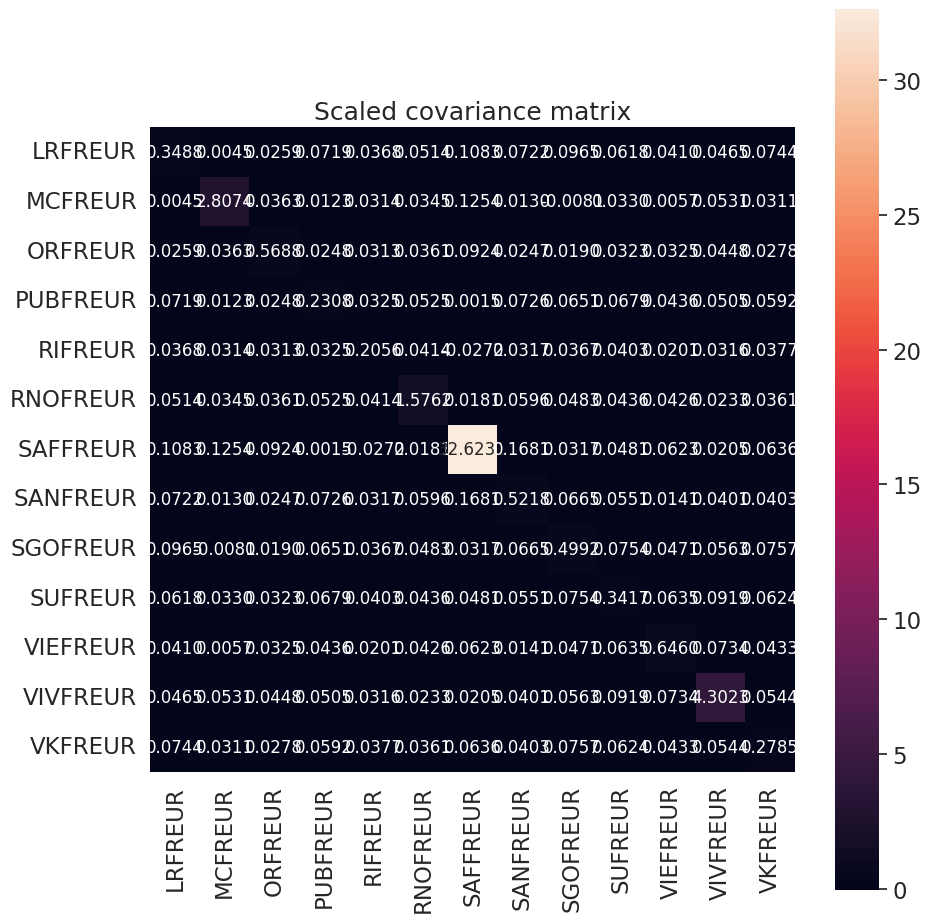

In [13]:
idx = 20


plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)

# We scale the values for a better visualisation
hm = sns.heatmap(var_cov[idx:, idx:, 1266]*1000,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.4f',
                 annot_kws={'size': 12},
                 yticklabels=cols[idx:],
                 xticklabels=cols[idx:])
plt.title('Scaled covariance matrix')
plt.tight_layout()
plt.show()

## Correlations

In [14]:
stds = []
for i in range(var_cov.shape[0]):
    stds.append(np.sqrt(var_cov[i, i, :]))

In [15]:
correlations = var_cov.copy()
for i in range(var_cov.shape[0]):
    for j in range(var_cov.shape[1]):
        correlations[i, j, :] = np.divide(np.divide(correlations[i, j, :], stds[i]), stds[j])

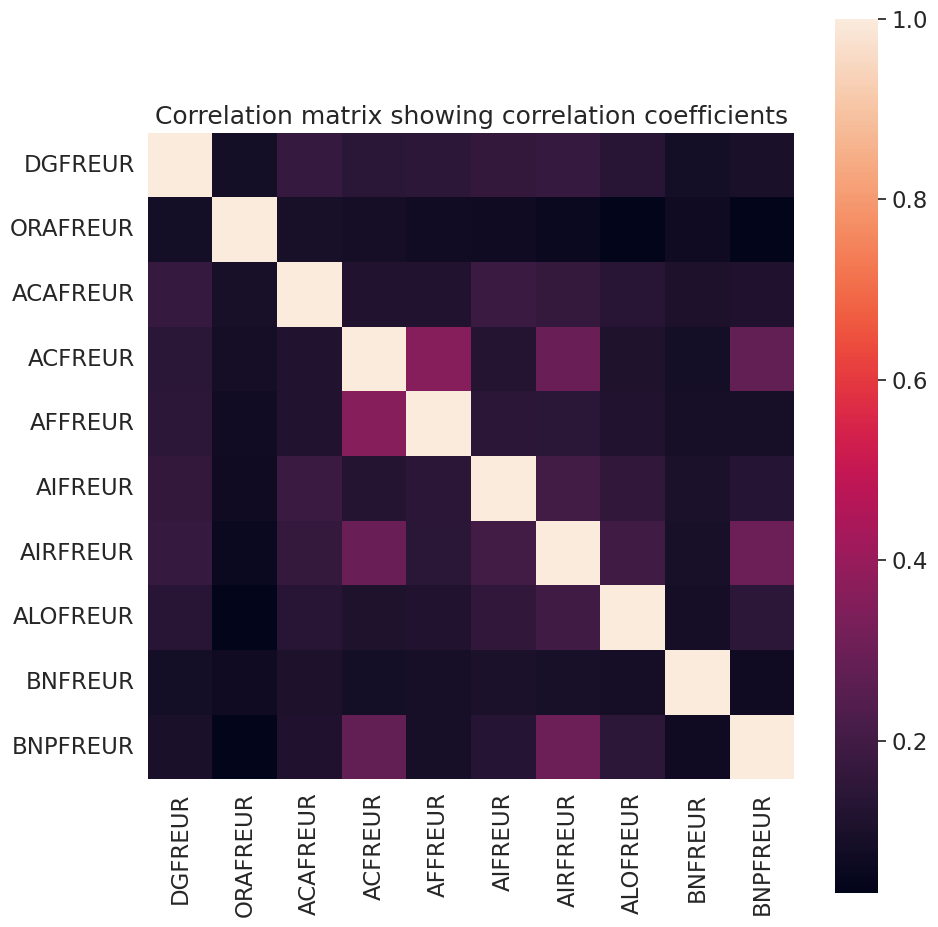

In [16]:
idx = 0
idx2 = 10

plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
hm = sns.heatmap(correlations[idx:idx2, idx:idx2, 1000],
                 cbar=True,
                 #annot=True,
                 square=True,
                 fmt='.4f',
                 annot_kws={'size': 12},
                 yticklabels=cols[idx:idx2],
                 xticklabels=cols[idx:idx2])
plt.title('Correlation matrix showing correlation coefficients')
plt.tight_layout()
plt.show()

In [17]:
# with open('data/corr_all_stocks.pickle', 'wb') as f:
#     pickle.dump(correlations, f)

## Matrix cleaning

#### BAHC

In [48]:
with open('data/cov_all_stocks.pickle', 'rb') as f:
    var_cov = pickle.load(f)

In [19]:
import bahc_1_9_tick_cov

one_year_window = 257
var_cov_bahc = np.zeros((33, 33, one_year_window))

In [23]:
# execution time for Nboot=100 is of approximately 8 hours in our personal laptops
d = len(dates)-one_year_window
for idx in tqdm(range(one_year_window)):
    log_rets = []
    for df in dfs:
        log_rets.append(dfs[df].loc[dates[d+idx-1]:dates[d+idx]].dropna())
    
    var_cov_bahc[:,:,idx] = bahc_1_9_tick_cov.filterCovariance(log_rets, K=1, Nboot=10)

  7%|▋         | 19/257 [01:57<24:29,  6.17s/it]


KeyboardInterrupt: 

In [ ]:
# with open('data/var_cov_bach.pickle', 'rb') as f:
#     var_cov_bach = pickle.load(f)

# with open('data/var_cov_bach.pickle', 'wb') as f:
#     pickle.dump(var_cov_bahc, f)

#### Average Oracle

In [49]:
from average_oracle import AO

In [55]:
var_cov_ao = np.zeros(var_cov.shape)
window = windows[1]
# there are different files to upload depending on the window chosen
ao_instance = AO(os.path.join(os.getcwd(), f'data/average_oracle_values/AO_Din{window}_N33-2018-2021.csv'))
for idx in tqdm(range(len(dates[1:]))):
    var_cov_ao[:,:,idx] = ao_instance.filter_covariance_AO(var_cov[:,:,idx-window+1:idx+1].mean(axis=2))

var_cov_ao = var_cov_ao[:,:,window:]

  0%|          | 0/1276 [00:00<?, ?it/s]/home/thomas/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice.
  
/home/thomas/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
100%|██████████| 1276/1276 [00:02<00:00, 429.64it/s]


#### RIE

In [ ]:
# We decided in the end not to use this method for the evaluation of results
from RIE import rie_est

In [368]:
var_cov_rie = np.zeros(var_cov.shape)

for idx in tqdm(range(var_cov.shape[2])):
    var_cov_rie[:,:,idx] = rie_est.get_rie(var_cov[:,:,idx-1])

100%|██████████| 1276/1276 [00:02<00:00, 454.81it/s]


## In-sample vs Realised volatility

In [57]:
# Initialize a list to store the Frobenius norms
frobenius_norms = []
# Get the matrix for which to calculate the Frobenius norm
matrix = var_cov_ao

# Loop through the number of windows in the matrix
for idx in range(var_cov.shape[2]-windows[1]-1): # K > 1
    # Calculate the difference between the mean of a window in the matrix and a single value for estimate not AO
    #diff = matrix[:,:,idx:idx+windows[1]].mean(axis=2) - var_cov[:,:,idx+windows[1]]
    # Calculate for average oracle, as it is already meaned for them
    diff = matrix[:,:,idx] - var_cov[:,:,idx+windows[1]]
    # Append the Frobenius norm of the difference to the list
    frobenius_norms.append(norm(diff, ord='fro'))

# Print the mean of the list of Frobenius norms
print(np.array(frobenius_norms).mean())

1.845180416611763


## MVP

In [58]:
with open('data/cov_all_stocks.pickle', 'rb') as f:
    var_cov = pickle.load(f)

In [59]:
def minimum_variance_portfolio(var_cov):
    # Create an array of ones of the same shape as the covariance matrix
    e = np.ones(var_cov.shape[0])
    # Invert the covariance matrix
    inv_var_cov = np.linalg.inv(var_cov)
    # Take the dot product of the inverted covariance matrix and the array of ones
    w = np.dot(inv_var_cov, e)
    # Normalize the weights to sum to 1
    w /= w.sum()
    # calculate w transposed * var_cov * w to get the variance of our portfolio
    var_portfolio = np.dot(np.dot(w.T, var_cov), w)
    return w, var_portfolio

In [60]:
#from the slides (to compare with our implementation)
def minimum_variance_portfolio2(Sigma):
    Sigma_inv = np.linalg.inv(Sigma)
    w_GVM = Sigma_inv.sum(axis=1)/Sigma_inv.sum()
    return w_GVM, 1

In [61]:
portfolio_variance = []
c = 0
w_star = []
for cov in range(var_cov.shape[2]):
    c+=1
    w, var_portfolio = minimum_variance_portfolio(var_cov[:, :, cov])
    # if windows != 1 e.g. 10 for empirical and bahc do an average of estimates
    w_star.append(w)
    portfolio_variance.append(np.sqrt(var_portfolio))

/home/thomas/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


## Intraday return

In [62]:
# it takes around two minutes
asset_returns = []
for asset in dfs:
    returns = dfs[asset].groupby(dfs[asset].index.date)['logret'].sum()
    asset_name = asset.name.split('-')[0]
    asset_returns.append(pd.DataFrame(returns).rename(columns={'logret': asset_name}))

In [63]:
with open('data/returns.pickle', 'rb') as f:
    asset_returns = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'data/returns.pickle'

In [64]:
from functools import reduce
returns = reduce(lambda df1,df2: pd.merge(df1, df2, left_index=True, right_index=True), asset_returns)
returns = np.exp(returns)-1

In [71]:
# Initialize lists to store the values
s_ratios = []
oos_returns = []
oos_std = []

# Loop through the rows of the `returns` DataFrame
for idx, (date, row) in enumerate(returns.iloc[1:].iterrows()):
    # Skip the first row
    if idx > 0:
        # Calculate the portfolio return
        portfolio_return = np.dot(w_star[idx-1], list(row))
        # Calculate the portfolio realized standard deviation
        # portfolio_realized_std = np.sqrt(np.dot(np.dot(w_star[initial_day+idx-2].T, var_cov[:,:,initial_day+idx-1:initial_day+idx].mean(axis=2)), w_star[initial_day+idx-2]))
        portfolio_realized_std = np.sqrt(np.dot(np.dot(w_star[idx-1].T, var_cov[:,:,idx]), w_star[idx-1]))
        # Calculate the undiscounted sharpe ratio
        ratio = portfolio_return / portfolio_realized_std
        
        # Append the portfolio return and standard deviation to their respective lists
        oos_returns.append(portfolio_return)
        oos_std.append(portfolio_realized_std)
        # Append the sharpe ratio to its list
        s_ratios.append(ratio)

In [72]:
oos_returns = np.array(oos_returns).mean()
oos_std = np.array(oos_std).mean()
ratio = oos_returns/oos_std
print(ratio, oos_returns, oos_std)

0.10722913961964317 0.001465663673235945 0.013668520314859002


## Visualisation of the results


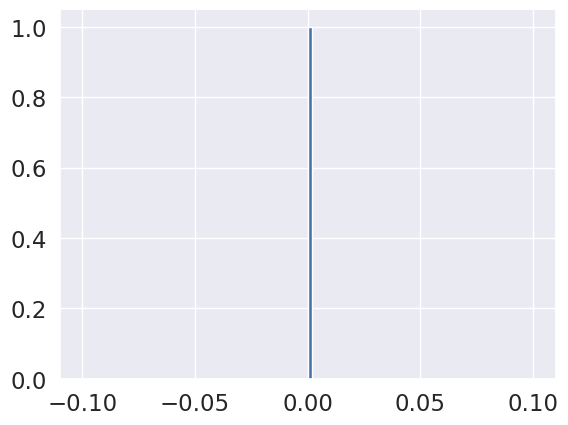

In [73]:
plot = plt.hist(oos_returns, bins=100, range = (-0.1,0.1))

In [ ]:
s_ratios = np.array(s_ratios)
average = s_ratios.mean()
std = s_ratios.std()
print(f'Average ratio: {round(average, 5)}', f'Average std: {round(std, 5)}')

Average ratio: -0.00712 Average std: 1.70039


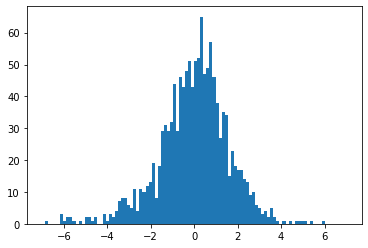

In [ ]:
plot = plt.hist(s_ratios, bins=100, range = (-7,7))